In [133]:
import numpy as np 
import numpy.ma as ma

import matplotlib.pyplot as plt
import matplotlib.colors as colors
import matplotlib

import datetime
from tqdm import tqdm

from astropy.stats import sigma_clip
from astropy.io import fits
from astropy.table import Table

from ResidualUtils import getwavs, getspecpath, getapstarpath, create_mask, get_selected_stars, get_residual, get_selected_stars

# Overview
To study the spectral features of the ISM in observed spectra, we need a reliable characterization of the spectral features of those background objects. We've produced a catalog of the median stellar residuals between APOGEE spectra and their corresponding ASPCAP fits, which can serve as a model of their typical deviations.

To produce our catalog, we grouped `ASPCAPSTAR` spectra by `TEFF`, `LOGG`, and `M_H` using the binning scheme described in [Ashok et al. 2021](https://doi.org/10.3847/1538-3881/abd7f1). After applying `APSTAR/ASSTAR` bitmasks and our own supplementary masks to remove pixels with high uncertainties, we calculate the median residual 
$$\langle R\rangle = \text{median}(F_\lambda / F_{\lambda}')$$
for $F_\lambda$ the combined stellar spectrum and $F_{\lambda}'$ the corresponding ASPCAP model.



In [134]:
# Read in some useful tables:
tabfile = '/uufs/chpc.utah.edu/common/home/sdss/dr17/apogee/spectro/aspcap/dr17/synspec_rev1/allStarLite-dr17-synspec_rev1.fits'
stars = Table.read(tabfile, hdu = 1) # allStarLite base file


# select all CA Cloud stars from the allStarLite file
CA_fields = ['CA_161-06_btx', 'CA_161-06_btx', 'CA_162-11_btx', 'CA_163-05_btx', 'CA_163-08_btx',
             'CA_165-07_btx', 'CA_165-10_btx']
CA_inds = np.unique(np.concatenate([np.where(stars['FIELD'] == field)[0] for field in CA_fields]))
CA_stars = stars[CA_inds]
CA_clean = CA_stars[np.invert(np.logical_or.reduce([np.isnan(CA_stars['TEFF']), np.isnan(CA_stars['LOGG']), 
                                           np.isnan(CA_stars['M_H'])]))]
# for our purposes, requires that all CA cloud stars have TEFF, LOGG, and M_H

select_bitmasked = np.where((np.bitwise_and(stars['ASPCAPFLAG'], 23) == 0) | 
                            (np.bitwise_and(stars['ASPCAPFLAG'], 19) == 0))[0] # perhaps I should also bitmask CA_clean

stars = stars[select_bitmasked]
stars = stars[np.where((stars['TEFF_ERR'] < 600) & (stars['LOGG_ERR'] < 0.5) & (stars['M_H_ERR'] < 0.3))[0]]
stars = stars[np.where(np.abs(stars['GLAT']) > 10)[0]] # clean up the allStarLite data file

/uufs/chpc.utah.edu/sys/installdir/python/3.6.3/lib/python3.6/site-packages/astropy/table/column.py:1020: RuntimeWarning: invalid value encountered in less
  result = getattr(super(), op)(other)


In [135]:
# get aspcapStar file path from an allstar table row
def get_aspcapStar(row):
    specdir = '/uufs/chpc.utah.edu/common/home/sdss/dr17/apogee/spectro/aspcap/dr17/synspec_rev1/{TELESCOPE}/{FIELD}/'
    specname = 'aspcapStar-dr17-{SOURCEID}.fits'
    telescope = np.array(row['TELESCOPE'], dtype = str)
    field = np.array(row['FIELD'], dtype = str)
    sourceid = np.array(row['APOGEE_ID'], dtype = str)
#     length = len(sourceid)
    path = (specdir + specname).format(TELESCOPE = telescope, FIELD = field, SOURCEID = sourceid)
    return path

# get apStar/asStar file path from an aspcapStar hdulist
def get_apStar(hdulist):
    specdir = '/uufs/chpc.utah.edu/common/home/sdss/dr17/apogee/spectro/redux/dr17/stars/{TELESCOPE}/{FIELD}/'
    telescope = str(hdulist[4].data['TELESCOPE'][0])
    field = str(hdulist[4].data['FIELD'][0])
    fname = str(hdulist[4].data['FILE'][0])
    path = ((specdir + fname).format(TELESCOPE = telescope, FIELD = field))
    return path

# get wavelength array for some aspcapStar/apStar hdulist; if no hdulist given, uses default values
# can be rv-corrected from the stellar rest frame to the observed frame
def get_wavs(hdulist = None, rv = 0):
    if hdulist is None:
        CRVAL1 = 4.179
        CDELT1 = 6e-06
        LEN = 8575
    else:
        header = hdulist[1].header
        CRVAL1 = header['CRVAL1']
        CDELT1 = header['CDELT1']
        LEN = header['NAXIS1']
        
    wavs = np.power(10, CRVAL1 + CDELT1 * np.arange(LEN))
    wavs = wavs * (1 + rv / 3e5) # allows for shifting to observed frame from rest frame
    return wavs 

# creates a mask from pixel-wise apStar/asStar bitmask
def create_mask(bitmask, flags = [0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15], skipflags = []): 
    # https://www.sdss.org/dr14/algorithms/bitmasks/#APOGEE_PIXMASK
    if type(flags) is not list:
        flags = [flags]
    if type(skipflags) is not list:
        skipflags = [skipflags]

    mask = np.zeros(bitmask.shape)
    for i in flags:
        if i not in skipflags:
            mask[np.bitwise_and(bitmask, 2**i) == 2**i] = 1
    return mask

# File Structure (subject to change)


In [136]:
# subject to change
meta = Table(fits.open('ResidualsFiles/meta_table.fits')[1].data)

# if I change the data structure, I'll make an equivalent get_residual function
def get_medres(teff, logg, m_h):
    rowselect = np.where(np.logical_and.reduce(
                    [teff >= meta['teff_low'], teff < meta['teff_high'], 
                    logg >= meta['logg_low'], logg < meta['logg_high'],
                   m_h >= meta['m_h_low'], m_h < meta['m_h_high']]))[0]
    if len(rowselect) != 1:
        return 
    
    
    row = meta[rowselect]
    j, k = (row['j_ind'], row['k_ind'])
    filename = row['fname'].item()
    hdulist = fits.open(filename)
    hdulist = np.array(hdulist)[1:].reshape(30,12)
    hdu = hdulist[j, k].item()
    return hdu # may want to make it return the path

# Example: Choose CA Cloud star, get median residual

In [141]:
# Choose an example star from our allStar file;
# get its corresponding aspcapStar file, apStar file, and median residual
# np.random.seed(1) # 235
# test_star = CA_clean[np.random.choice(len(CA_clean))]

test_star = CA_clean[235]
test_aspcap = fits.open(get_aspcapStar(test_star))
test_apstar = fits.open(get_apStar(test_aspcap))
test_medres = get_medres(test_star['TEFF'], test_star['LOGG'], test_star['M_H'])

# get bitmask for the stellar spectrum from apStar bitmask
mask = create_mask(test_apstar[3].data[0], skipflags = [10, 11]) # skips medium and low persistence

/uufs/chpc.utah.edu/sys/installdir/python/3.6.3/lib/python3.6/site-packages/IPython/core/pylabtools.py:122: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


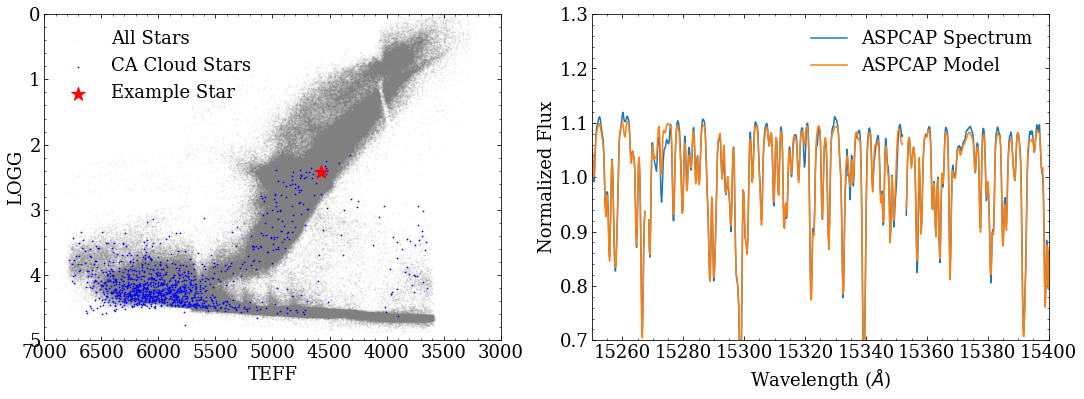

In [153]:
# Visualize our chosen star on the HR diagram and take a look at the ASPCAP spectrum
fig, axs = plt.subplots(nrows = 1, ncols = 2, figsize = (18, 6))

axs[0].scatter(stars['TEFF'], stars['LOGG'], c = 'grey', alpha = 0.1, s = 0.5, label = 'All Stars')
axs[0].scatter(CA_clean['TEFF'], CA_clean['LOGG'], c = 'blue', s = 0.5, label = 'CA Cloud Stars')
axs[0].scatter(test_star['TEFF'], test_star['LOGG'], c = 'r', marker = '*', s = 200, label = 'Example Star')
axs[0].set_xlim(7000,3000)
axs[0].set_ylim(5,0)
axs[0].set_xlabel('TEFF')
axs[0].set_ylabel('LOGG')
axs[0].legend(frameon = False)


wavs = get_wavs()
axs[1].plot(wavs, ma.array(test_aspcap[1].data, mask = mask), label = 'ASPCAP Spectrum')
axs[1].plot(wavs, ma.array(test_aspcap[3].data, mask = mask), label = 'ASPCAP Model')
axs[1].set_xlim(15250, 15400)
axs[1].set_ylim(0.7, 1.3)
axs[1].set_xlabel('Wavelength ($\AA$)')
axs[1].set_ylabel('Normalized Flux')
axs[1].legend(frameon = False)

plt.show()

## Check out the corresponding median residual

Median residual bin:
	 TEFF [ 4550 4600 ]
	 LOGG [ 2.4 2.6 ]
	 M_H [ 0.1 0.3 ]

 Stars in bin: 877


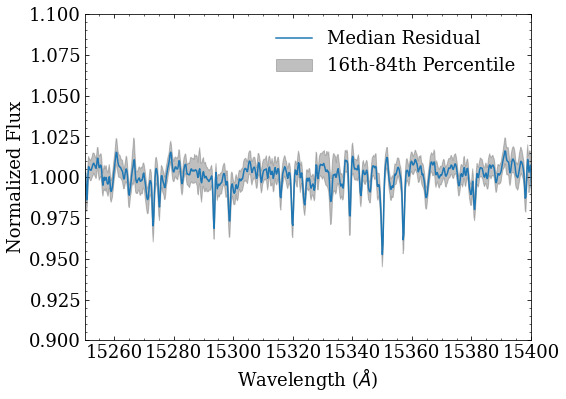

In [155]:
# get some information about our median residual!
header = test_medres.header
print('Median residual bin:')
print('\t TEFF [', header['TMIN'], header['TMAX'], ']')
print('\t LOGG [', header['GMIN'], header['GMAX'], ']')
print('\t M_H [', header['MMIN'], header['MMAX'], ']')
print('\n Stars in bin:', header['NBIN'])

fig, ax = plt.subplots(figsize = (8,6))
ax.plot(wavs, test_medres.data[0], label = 'Median Residual')
ax.fill_between(wavs, test_medres.data[5], test_medres.data[4], color = 'grey', 
                alpha = 0.5, label = '16th-84th Percentile')
ax.set_xlim(15250, 15400)
ax.set_ylim(0.9, 1.1)
ax.set_xlabel('Wavelength ($\AA$)')
ax.set_ylabel('Normalized Flux')
ax.legend(frameon = False)
plt.show()

## Applying median residual corrections to stellar residuals

/uufs/chpc.utah.edu/sys/installdir/python/3.6.3/lib/python3.6/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in true_divide
  


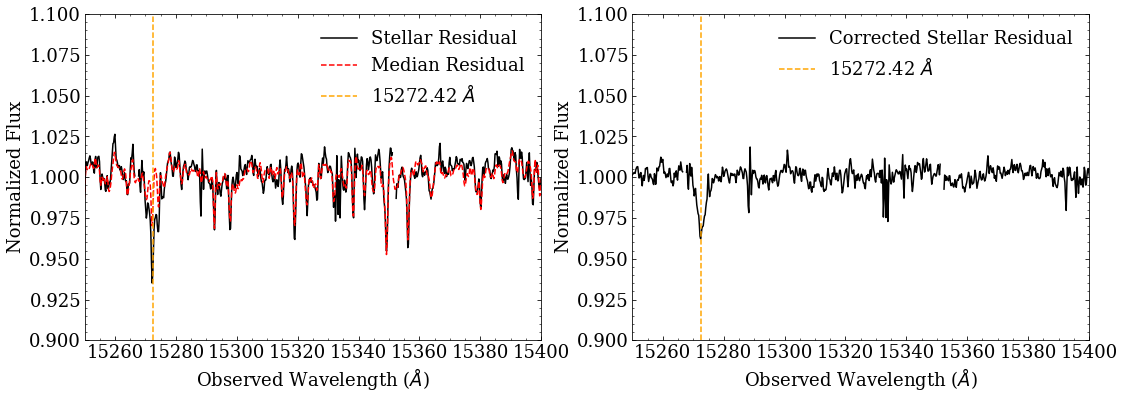

In [152]:
# Calculate ASPCAP residual with and without correction from our median residual
dib_position = 15272.42
fig, axs = plt.subplots(nrows = 1, ncols = 2, figsize = (18, 6))
# fig, axs = plt.subplots(nrows = 2, ncols = 1, figsize = (10, 14))


wavs_rv = get_wavs(rv = test_star['VHELIO_AVG'])
test_residual = ma.array(test_aspcap[1].data / test_aspcap[3].data, mask = mask)

axs[0].plot(wavs_rv, test_residual, label = 'Stellar Residual', c= 'k')
axs[0].plot(wavs_rv, test_medres.data[0], label = 'Median Residual', c = 'r', linestyle = 'dashed')
axs[0].plot([dib_position, dib_position], [0.9, 1.1], 
            label = '15272.42 $\AA$', c = 'orange', linestyle = 'dashed')
axs[0].set_xlim(15250, 15400)
axs[0].set_ylim(0.9, 1.1)
axs[0].set_xlabel('Observed Wavelength ($\AA$)')
axs[0].set_ylabel('Normalized Flux')
axs[0].legend(frameon = False)


axs[1].plot(wavs_rv, test_residual / test_medres.data[0], label = 'Corrected Stellar Residual', c = 'k')
axs[1].set_xlim(15250, 15400)
axs[1].plot([dib_position, dib_position], [0.9, 1.1], 
            label = '15272.42 $\AA$', color = 'orange', linestyle = 'dashed')
axs[1].set_ylim(0.9, 1.1)
axs[1].set_xlabel('Observed Wavelength ($\AA$)')
axs[1].set_ylabel('Normalized Flux')
axs[1].legend(frameon = False)

plt.show()